### generate_credit_transition_matrix_with_withdraw_prob

Generates a credit transition matrix with randomness, centered around a specified withdraw probability.

In [1]:
import numpy as np
import pandas as pd

def generate_credit_transition_matrix_with_withdraw_prob(withdraw_prob):
    n_ratings = 10
    n_columns = 12  # Including withdraw and default columns
    matrix = np.zeros((n_ratings, n_columns))
    
    stddev = withdraw_prob / 10
    
    # Specified default rates
    default_rates = np.array([0.00005, 0.0001, 0.0004, 0.0009, 0.0025, 
                              0.007, 0.0128, 0.0601, 0.1575, 0.3537])
    
    # Main diagonal probabilities for each rating
    main_diagonal_probs = [0.87, 0.85, 0.82, 0.79, 0.77, 0.74, 0.72, 0.69, 0.65, 0.53]

    for i in range(n_ratings):
        # Assign specified default probability
        default_prob = default_rates[i]
        
        # Assign withdraw probability following a normal distribution centered around withdraw_prob
        withdraw_prob_sample = np.random.normal(withdraw_prob, stddev)
        
        # Ensure withdraw probability is within the valid range [0, 1]
        withdraw_prob_sample = max(0, min(withdraw_prob_sample, 1))
        
        # Calculate the remaining probability for other transitions
        remaining_prob = 1 - default_prob - withdraw_prob_sample
        
        # Set main diagonal probability
        main_diagonal = np.random.normal(main_diagonal_probs[i], main_diagonal_probs[i]/100)
        
        # Calculate side probabilities based on the number of adjacent ratings
        num_adjacent_ratings = min(i, n_ratings - 1 - i)
        if i == 0:  # Top rating
            side_prob = (remaining_prob - main_diagonal) / 2  # Only two adjacent ratings (downwards)
        elif i == 9:  # Bottom rating
            side_prob = (remaining_prob - main_diagonal) / 2  # Only two adjacent ratings (upwards)
        elif num_adjacent_ratings == 1:
            side_prob = (remaining_prob - main_diagonal) / 3
        elif num_adjacent_ratings == 2:
            side_prob = (remaining_prob - main_diagonal) / 4
        elif num_adjacent_ratings == 3:
            side_prob = (remaining_prob - main_diagonal) / 5
        else:
            side_prob = (remaining_prob - main_diagonal) / 6
        
        # Set main diagonal
        matrix[i, i] = main_diagonal
        
        # Set probabilities for adjacent ratings with randomness
        for j in range(1, 4):
            if i - j >= 0:  # Lower adjacent ratings, i.e. higher ratings
                matrix[i, i - j] = max(0, side_prob * (4 - j) * np.random.uniform(0.7, 0.9))
            if i + j < n_ratings:  # Upper adjacent ratings, i.e. lower ratings
                matrix[i, i + j] = max(0, side_prob * (4 - j) * np.random.uniform(1.1, 1.3))
        
        # Normalize probabilities for other states while keeping main diagonal fixed
        before_i = np.sum(matrix[i, :i])
        after_i = np.sum(matrix[i, i+1:n_ratings])
        total_adjacent_prob = before_i + after_i
        if total_adjacent_prob > 0:
            matrix[i, :i] *= (remaining_prob - main_diagonal) / total_adjacent_prob
            matrix[i, i+1:n_ratings] *= (remaining_prob - main_diagonal) / total_adjacent_prob
        
        matrix[i, -2] = withdraw_prob_sample  # Withdraw probability
        matrix[i, -1] = default_prob  # Default probability

    # Ensure transition probabilities for Rating 1 and Rating 10 are correctly adjusted
    matrix[0, 1] = max(matrix[0, 1], 1e-5)  # Ensure non-zero probability to transition to Rating 2
    matrix[0, 2] = max(matrix[0, 2], 1e-5)  # Ensure non-zero probability to transition to Rating 3
    matrix[9, 8] = max(matrix[9, 8], 1e-5)  # Ensure non-zero probability to transition to Rating 9
    matrix[9, 7] = max(matrix[9, 7], 1e-5)  # Ensure non-zero probability to transition to Rating 8
    
    # Define row and column labels
    row_labels = [f'Rating {i+1}' for i in range(10)]
    column_labels = [f'Rating {i+1}' for i in range(10)] + ['Withdraw', 'Default']

    # Create a DataFrame with labels
    transition_matrix_df = pd.DataFrame(matrix, index=row_labels, columns=column_labels)

    return transition_matrix_df

# Example usage
withdraw_prob = 0.1  # Centered around value% withdraw probability
transition_matrix_df = generate_credit_transition_matrix_with_withdraw_prob(withdraw_prob)
transition_matrix_df

,Rating 1,Rating 2,Rating 3,Rating 4,Rating 5,Rating 6,Rating 7,Rating 8,Rating 9,Rating 10,Withdraw,Default
Rating 1,0.878478,0.009684,0.006364,0.003136,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.102287,0.00005
Rating 2,0.020588,0.848005,0.026864,0.018629,0.009317,0.000000,0.000000,0.000000,0.000000,0.000000,0.076496,0.00010
Rating 3,0.009639,0.015877,0.825646,0.026299,0.015779,0.008390,0.000000,0.000000,0.000000,0.000000,0.097969,0.00040
Rating 4,0.006217,0.012194,0.017702,0.800568,0.028061,0.018821,0.009377,0.000000,0.000000,0.000000,0.106160,0.00090
Rating 5,0.000000,0.008676,0.020008,0.030956,0.755365,0.039996,0.025766,0.014502,0.000000,0.000000,0.102232,0.00250
Rating 6,0.000000,0.000000,0.009976,0.024425,0.032805,0.740606,0.054442,0.036396,0.016117,0.000000,0.078233,0.00700
Rating 7,0.000000,0.000000,0.000000,0.010294,0.023764,0.034747,0.715980,0.049712,0.035082,0.018028,0.099593,0.01280
Rating 8,0.000000,0.000000,0.000000,0.000000,0.009524,0.018213,0.029400,0.704934,0.045474,0.028223,0.104134,0.06010
Rating 9,0.000000,0.000000,0.000000,0.000000,0.000000,0.007596,0.015656,0.024781,0.652442,0.036555,0.105469,0.15750
Rating 10,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.002787,0.006419,0.009797,0.530514,0.096784,0.35370


### redistribute_withdraw_prob
redistribute the withdraw probability to the 10 existing probabilities plus the default probability proportionally

In [2]:
import numpy as np
import pandas as pd

def redistribute_withdraw_prob(transition_matrix_df):
    transition_matrix = transition_matrix_df.values
    n_ratings = transition_matrix.shape[0]
    
    # Create a new matrix to store the adjusted probabilities
    adjusted_matrix = np.zeros((n_ratings, n_ratings + 1))
    
    for i in range(n_ratings):
        withdraw_prob = transition_matrix[i, -2]
        default_prob = transition_matrix[i, -1]
        remaining_prob = 1 - withdraw_prob

        for j in range(n_ratings):
            adjusted_matrix[i, j] = transition_matrix[i, j] + withdraw_prob * (transition_matrix[i, j] / remaining_prob)
        
        adjusted_matrix[i, -1] = default_prob + withdraw_prob * (default_prob / remaining_prob)

    # Define row and column labels
    row_labels = [f'Rating {i+1}' for i in range(10)]
    column_labels = [f'Rating {i+1}' for i in range(10)] + ['Default']

    # Create a DataFrame with labels
    adjusted_transition_matrix_df = pd.DataFrame(adjusted_matrix, index=row_labels, columns=column_labels)
    
    return adjusted_transition_matrix_df

# Example usage
withdraw_removed_transition_matrix_df = redistribute_withdraw_prob(transition_matrix_df)
withdraw_removed_transition_matrix_df

,Rating 1,Rating 2,Rating 3,Rating 4,Rating 5,Rating 6,Rating 7,Rating 8,Rating 9,Rating 10,Default
Rating 1,0.978573,0.010788,0.007089,0.003494,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000056
Rating 2,0.022294,0.918248,0.029089,0.020172,0.010089,0.000000,0.000000,0.000000,0.000000,0.000000,0.000108
Rating 3,0.010686,0.017602,0.915318,0.029155,0.017493,0.009302,0.000000,0.000000,0.000000,0.000000,0.000443
Rating 4,0.006956,0.013642,0.019804,0.895650,0.031394,0.021057,0.010491,0.000000,0.000000,0.000000,0.001007
Rating 5,0.000000,0.009664,0.022286,0.034481,0.841380,0.044550,0.028701,0.016153,0.000000,0.000000,0.002785
Rating 6,0.000000,0.000000,0.010823,0.026498,0.035589,0.803464,0.059063,0.039485,0.017485,0.000000,0.007594
Rating 7,0.000000,0.000000,0.000000,0.011432,0.026393,0.038590,0.795174,0.055210,0.038963,0.020022,0.014216
Rating 8,0.000000,0.000000,0.000000,0.000000,0.010631,0.020330,0.032817,0.786874,0.050760,0.031503,0.067086
Rating 9,0.000000,0.000000,0.000000,0.000000,0.000000,0.008492,0.017502,0.027703,0.729368,0.040865,0.176070
Rating 10,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.003086,0.007106,0.010846,0.587361,0.391601


### redistribute_half_withdraw_prob
redistribute half of the withdraw probability to the 10 existing probabilities proportionally, and another half proportionally to the 10 existing probabilities plus the default probability

In [54]:
import numpy as np
import pandas as pd

def redistribute_half_withdraw_prob(transition_matrix_df):
    transition_matrix = transition_matrix_df.values
    n_ratings = transition_matrix.shape[0]
    
    # Create a new matrix to store the adjusted probabilities
    adjusted_matrix = np.zeros((n_ratings, n_ratings + 1))
    
    for i in range(n_ratings):
        withdraw_prob = transition_matrix[i, -2]
        default_prob = transition_matrix[i, -1]
        remaining_prob = 1 - withdraw_prob - default_prob
        
        existing_probs = transition_matrix[i, :n_ratings]
        sum_existing_probs = np.sum(existing_probs)
        
        # Distribute half of the withdraw prob proportionally among existing probabilities
        proportional_withdraw_existing = (existing_probs / sum_existing_probs) * (0.5 * withdraw_prob)
        
        for j in range(n_ratings):
            adjusted_matrix[i, j] = (existing_probs[j] + proportional_withdraw_existing[j]) / (1 - 0.5 * withdraw_prob)
        
        # Adjust default probability
        adjusted_matrix[i, -1] = default_prob / (1 - 0.5 * withdraw_prob)
    
    # Define row and column labels
    row_labels = [f'Rating {i+1}' for i in range(10)]
    column_labels = [f'Rating {i+1}' for i in range(10)] + ['Default']

    # Create a DataFrame with labels
    adjusted_transition_matrix_df = pd.DataFrame(adjusted_matrix, index=row_labels, columns=column_labels)
    
    return adjusted_transition_matrix_df

# Example usage
adjusted_transition_matrix_df = redistribute_half_withdraw_prob(transition_matrix_df)
adjusted_transition_matrix_df

,Rating 1,Rating 2,Rating 3,Rating 4,Rating 5,Rating 6,Rating 7,Rating 8,Rating 9,Rating 10,Default
Rating 1,0.970837,0.014392,0.009928,0.004790,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000053
Rating 2,0.020709,0.922079,0.028135,0.018840,0.010133,0.000000,0.000000,0.000000,0.000000,0.000000,0.000105
Rating 3,0.012761,0.021311,0.908312,0.028967,0.018145,0.010081,0.000000,0.000000,0.000000,0.000000,0.000423
Rating 4,0.008454,0.017103,0.027281,0.870162,0.037895,0.026378,0.011784,0.000000,0.000000,0.000000,0.000944
Rating 5,0.000000,0.009670,0.018389,0.024638,0.862786,0.041837,0.026832,0.013219,0.000000,0.000000,0.002630
Rating 6,0.000000,0.000000,0.010700,0.025741,0.036814,0.817735,0.049240,0.033624,0.018816,0.000000,0.007329
Rating 7,0.000000,0.000000,0.000000,0.011680,0.021111,0.033549,0.815009,0.052766,0.034483,0.017946,0.013455
Rating 8,0.000000,0.000000,0.000000,0.000000,0.011851,0.023179,0.038124,0.775540,0.054505,0.033749,0.063052
Rating 9,0.000000,0.000000,0.000000,0.000000,0.000000,0.011152,0.023421,0.032305,0.721006,0.047664,0.164452
Rating 10,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.002993,0.005272,0.009770,0.608668,0.373296


### simulate_transitions_matrix

Initialize Distribution: Start with an identity matrix for the initial distribution of obligors.
Nested Loops for Redistribution:

Outer loop: Iterate over the quarters.
Middle loop: Iterate over each rating.
Inner loop: Iterate over each possible transition from one rating to another.
Calculate the transitions and update the next distribution matrix.
Accumulate Withdraws and Defaults:

At the beginning of each new period, add the cumulative withdraws and defaults from the previous period.
Update the cumulative withdraws and defaults based on the current period's transitions.

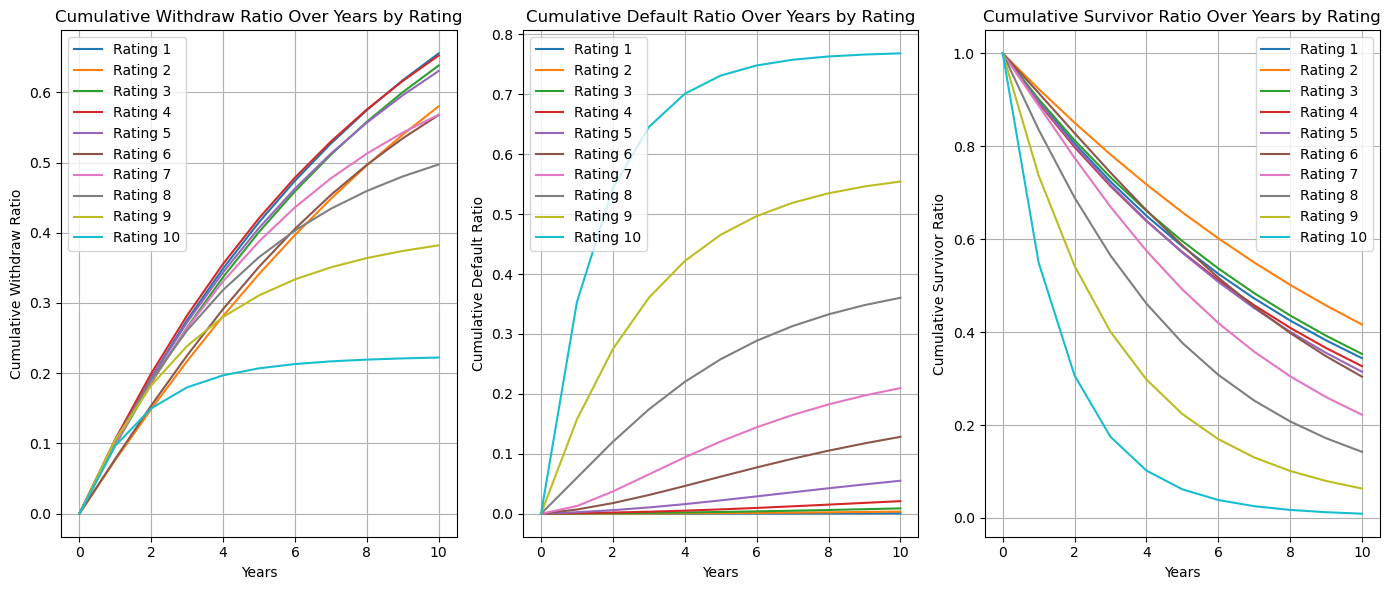

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def simulate_transitions_matrix(transition_matrix, quarters=11, lgd=1.0, ead=1.0):
    n_ratings = transition_matrix.shape[0]  # Number of ratings (excluding Withdraw and Default)
    n_columns = transition_matrix.shape[1]  # Number of states including Withdraw and Default

    # Initialize matrices to store cumulative results
    cumulative_withdraws = np.zeros((quarters, n_ratings))
    cumulative_defaults = np.zeros((quarters, n_ratings))
    cumulative_survivors = np.zeros((quarters, n_ratings))
    ecl_per_quarter = np.zeros((quarters, n_ratings))  # To store ECL for each quarter and rating
    
    for i in range(n_ratings):
        cumulative_survivors[0, i] = 1

    # Initial distribution of obligors (start with identity matrix for initial distribution)
    current_distribution = np.eye(n_ratings)

    for t in range(1, quarters):
        next_distribution = np.zeros_like(current_distribution)

        for i in range(n_ratings):  # For each rating
            for j in range(n_ratings):  # For each possible transition from rating i to rating j
                if current_distribution[i, j] > 0:
                    transitions = current_distribution[i, j] * transition_matrix.iloc[j].values

                    # Update next_distribution matrix
                    next_distribution[i, :n_ratings] += transitions[:n_ratings]
                    
                    # Accumulate withdraws and defaults for each rating
                    if cumulative_withdraws[t, i] == 0 and cumulative_defaults[t, i] == 0:
                        cumulative_withdraws[t, i] = cumulative_withdraws[t - 1, i]
                        cumulative_defaults[t, i] = cumulative_defaults[t - 1, i]
                    
                    cumulative_withdraws[t, i] += transitions[-2]
                    cumulative_defaults[t, i] += transitions[-1]
            
            cumulative_survivors[t, i] = np.sum(next_distribution[i, :n_ratings])
            default_count = cumulative_defaults[t, i]
            ecl_per_quarter[t, i] = default_count * lgd * ead

        current_distribution = next_distribution

    cumulative_ecl = np.sum(ecl_per_quarter, axis=0)

    return cumulative_withdraws, cumulative_defaults, cumulative_survivors, ecl_per_quarter, cumulative_ecl

# Simulate the transitions over 11 unit times
quarters = 11
cumulative_withdraws, cumulative_defaults, cumulative_survivors, ecl_per_quarter, cumulative_ecl = simulate_transitions_matrix(transition_matrix_df, quarters)

# Plot the results
plt.figure(figsize=(14, 6))

# Plot Withdraw rates over time
plt.subplot(1, 3, 1)
for i in range(10):
    plt.plot(range(quarters), cumulative_withdraws[:, i], label=f'Rating {i+1}')
plt.xlabel('Years')
plt.ylabel('Cumulative Withdraw Ratio')
plt.title('Cumulative Withdraw Ratio Over Years by Rating')
plt.legend()
plt.grid(True)

# Plot Default rates over time
plt.subplot(1, 3, 2)
for i in range(10):
    plt.plot(range(quarters), cumulative_defaults[:, i], label=f'Rating {i+1}')
plt.xlabel('Years')
plt.ylabel('Cumulative Default Ratio')
plt.title('Cumulative Default Ratio Over Years by Rating')
plt.legend()
plt.grid(True)

# Plot Survivors rates over time
plt.subplot(1, 3, 3)
for i in range(10):
    plt.plot(range(quarters), cumulative_survivors[:, i], label=f'Rating {i+1}')
plt.xlabel('Years')
plt.ylabel('Cumulative Survivor Ratio')
plt.title('Cumulative Survivor Ratio Over Years by Rating')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [56]:
def simulate_transitions_matrix_without_withdraw(transition_matrix, quarters=11, lgd=1.0, ead=1.0):
    n_ratings = transition_matrix.shape[0]  # Number of ratings (excluding Withdraw and Default)
    n_columns = transition_matrix.shape[1]  # Number of states including Default

    # Initialize matrices to store cumulative results
    cumulative_defaults = np.zeros((quarters, n_ratings))
    cumulative_survivors = np.zeros((quarters, n_ratings))
    
    for i in range(n_ratings):
        cumulative_survivors[0, i] = 1

    # Initial distribution of obligors (start with identity matrix for initial distribution)
    current_distribution = np.eye(n_ratings)

    for t in range(1, quarters):
        next_distribution = np.zeros_like(current_distribution)

        for i in range(n_ratings):  # For each rating
            for j in range(n_ratings):  # For each possible transition from rating i to rating j
                if current_distribution[i, j] > 0:
                    transitions = current_distribution[i, j] * transition_matrix.iloc[j].values

                    # Update next_distribution matrix
                    next_distribution[i, :n_ratings] += transitions[:n_ratings]
                    
                    # Accumulate defaults for each rating
                    if cumulative_defaults[t, i] == 0:
                        cumulative_defaults[t, i] = cumulative_defaults[t - 1, i]
                    
                    cumulative_defaults[t, i] += transitions[-1]
            
            cumulative_survivors[t, i] = np.sum(next_distribution[i, :n_ratings])
            default_count = cumulative_defaults[t, i]

        current_distribution = next_distribution

    return cumulative_defaults, cumulative_survivors


Check that the sum of all the probabilities (10 ratings + withdraw + default) at each time (9 quarters) for each original rating (1 to 10) equals 1.

In [59]:
for i in range(10):
    sum = cumulative_withdraws[:, i] + cumulative_defaults[:, i] + cumulative_survivors[:, i]
    print(sum)

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


### calculate_default_rates 
Calculate the Moody's withdrawal-adjusted, conventional, and withdrawal-removed default rates given the CTM.

* the first table of default rate is calculated based on the original CTM(with complete withdraw)

* the second table of default rate is calculated based on the 50% withdraw adjusted CTM

* the third table of default rate is calculated based on the withdraw removed CTM

In [60]:
def calculate_default_rates(cumulative_defaults, cumulative_withdraws, cumulative_survivors):
    # Extract first year and second year data
    defaults_first_year = cumulative_defaults[5, :]
    withdraws_first_year = cumulative_withdraws[5, :]
    survivors_first_year = cumulative_survivors[5, :]
    
    defaults_second_year = cumulative_defaults[10, :]
    withdraws_second_year = cumulative_withdraws[10, :]
    survivors_second_year = cumulative_survivors[10, :]
    
    # Compute default rates for the first and second years
    DR_1_orig = defaults_first_year / (defaults_first_year + survivors_first_year)
    DR_1_adjusted_1 = defaults_first_year / (defaults_first_year + survivors_first_year 
                                             + 0.5 * withdraws_first_year)
    DR_1_adjusted_2 = defaults_first_year / (defaults_first_year + survivors_first_year 
                                             + withdraws_first_year)

    DR_2_orig = (defaults_second_year - defaults_first_year) / (defaults_second_year - defaults_first_year 
                                                                + survivors_second_year)
    DR_2_adjusted_1 = (defaults_second_year - defaults_first_year) / (defaults_second_year - defaults_first_year 
                                                                      + survivors_second_year 
                                                                      + 0.5 * (withdraws_second_year - withdraws_first_year))
    DR_2_adjusted_2 = (defaults_second_year - defaults_first_year) / (defaults_second_year - defaults_first_year 
                                                                      + survivors_second_year 
                                                                      + (withdraws_second_year - withdraws_first_year))
    
    return (DR_1_orig, DR_1_adjusted_1, DR_1_adjusted_2), (DR_2_orig, DR_2_adjusted_1, DR_2_adjusted_2)

def format_default_rates(default_rates):
    return [np.round(rate, 6) for rate in default_rates]

# Calculate default rates
default_rates_first_year, default_rates_second_year = calculate_default_rates(cumulative_defaults, 
                                                                              cumulative_withdraws, 
                                                                              cumulative_survivors)

# Format default rates for readability
formatted_default_rates_first_year = [format_default_rates(rate) for rate in default_rates_first_year]
formatted_default_rates_second_year = [format_default_rates(rate) for rate in default_rates_second_year]

# Create DataFrame to display the default rates
df_default_rates_first_year = pd.DataFrame({
    'Rating': [f'{i+1}' for i in range(10)],
    'WTD removed': formatted_default_rates_first_year[0],
    '0.5 * WTD': formatted_default_rates_first_year[1],
    'WTD': formatted_default_rates_first_year[2]
})

df_default_rates_second_year = pd.DataFrame({
    'Rating': [f'{i+1}' for i in range(10)],
    'WTD removed': formatted_default_rates_second_year[0],
    '0.5 * WTD': formatted_default_rates_second_year[1],
    'WTD': formatted_default_rates_second_year[2]
})

# Display the DataFrames
print("\nOriginal CTM(with complete withdraw)")

print("\nDefault Rates for the First 5 unit time:")
print(df_default_rates_first_year)

print("\nDefault Rates for the First 10 unit time:")
print(df_default_rates_second_year)


Original CTM(with complete withdraw)

Default Rates for the First 5 unit time:
  Rating  WTD removed  0.5 * WTD       WTD
0      1     0.000507   0.000369  0.000290
1      2     0.001486   0.001139  0.000924
2      3     0.005033   0.003659  0.002875
3      4     0.012831   0.009709  0.007808
4      5     0.034949   0.026232  0.020996
5      6     0.094213   0.072621  0.059080
6      7     0.187520   0.143648  0.116412
7      8     0.399389   0.317943  0.264089
8      9     0.655092   0.553497  0.479182
9     10     0.927391   0.813129  0.723934

Default Rates for the First 10 unit time:
  Rating  WTD removed  0.5 * WTD       WTD
0      1     0.001696   0.001240  0.000978
1      2     0.006562   0.004975  0.004007
2      3     0.017416   0.012856  0.010188
3      4     0.041848   0.031631  0.025423
4      5     0.088107   0.066841  0.053845
5      6     0.172412   0.133331  0.108693
6      7     0.278199   0.217616  0.178700
7      8     0.407783   0.326384  0.272074
8      9     0.55

In [61]:
df_default_rates_first_year

,Rating,WTD removed,0.5 * WTD,WTD
0,1,0.000507,0.000369,0.000290
1,2,0.001486,0.001139,0.000924
2,3,0.005033,0.003659,0.002875
3,4,0.012831,0.009709,0.007808
4,5,0.034949,0.026232,0.020996
5,6,0.094213,0.072621,0.059080
6,7,0.187520,0.143648,0.116412
7,8,0.399389,0.317943,0.264089
8,9,0.655092,0.553497,0.479182
9,10,0.927391,0.813129,0.723934


In [62]:
df_default_rates_second_year

,Rating,WTD removed,0.5 * WTD,WTD
0,1,0.001696,0.001240,0.000978
1,2,0.006562,0.004975,0.004007
2,3,0.017416,0.012856,0.010188
3,4,0.041848,0.031631,0.025423
4,5,0.088107,0.066841,0.053845
5,6,0.172412,0.133331,0.108693
6,7,0.278199,0.217616,0.178700
7,8,0.407783,0.326384,0.272074
8,9,0.554670,0.457673,0.389550
9,10,0.808855,0.694606,0.608637


### calculate_default_rates_withdraw_removed

* For the 2nd CTM(50% withdraw adjusted) and the 3rd CTM(withdraw removed), the function computes the default rates of the ten ratings using the P_Default/(P_Default + P_Survivor) due to the fact that the matrix does not contain withdraw column.

In [27]:
 def calculate_default_rates_withdraw_removed(cumulative_defaults, cumulative_survivors):
    # Extract first year and second year data
    defaults_first_year = cumulative_defaults[5, :]
    survivors_first_year = cumulative_survivors[5, :]
    
    defaults_second_year = cumulative_defaults[10, :]
    survivors_second_year = cumulative_survivors[10, :]
    
    # Compute default rates for the first and second years
    default_rates_first_year = defaults_first_year / (defaults_first_year + survivors_first_year)
    
    default_rates_second_year = (defaults_second_year - defaults_first_year) / (defaults_second_year - defaults_first_year 
                                                                + survivors_second_year)
    
    return default_rates_first_year, default_rates_second_year

### 50% withdraw adjusted CTM year 1 & year 2 default rate

In [75]:
# Simulate the transitions over 10 quarters
quarters = 11
cumulative_defaults, cumulative_survivors = simulate_transitions_matrix_without_withdraw(adjusted_transition_matrix_df, quarters)

# Calculate default rates
default_rates_first_year, default_rates_second_year = calculate_default_rates_withdraw_removed(cumulative_defaults, cumulative_survivors)

# Format default rates for readability
formatted_default_rates_first_year = format_default_rates(default_rates_first_year)
formatted_default_rates_second_year = format_default_rates(default_rates_second_year)

# Create DataFrame to display the default rates
df_default_rates_first_year = pd.DataFrame({
    'Rating': [f'{i+1}' for i in range(10)],
    'WTD': formatted_default_rates_first_year
})

df_default_rates_second_year = pd.DataFrame({
    'Rating': [f'{i+1}' for i in range(10)],
    'WTD': formatted_default_rates_second_year
})

# Print default rates for the first and second years
print("\n50% withdraw adjusted CTM")

print("\nDefault Rates for the First Year:")
print(df_default_rates_first_year)

print("\nDefault Rates for the Second Year:")
print(df_default_rates_second_year)


50% withdraw adjusted CTM

Default Rates for the First Year:
  Rating       WTD
0      1  0.000394
1      2  0.001245
2      3  0.003964
3      4  0.010583
4      5  0.028548
5      6  0.078158
6      7  0.156639
7      8  0.337734
8      9  0.583701
9     10  0.886124

Default Rates for the Second Year:
  Rating       WTD
0      1  0.001295
1      2  0.005413
2      3  0.013248
3      4  0.033361
4      5  0.070037
5      6  0.139693
6      7  0.229441
7      8  0.344452
8      9  0.482751
9     10  0.759159


In [74]:
df_default_rates_first_year

,Rating,WTD
0,1,0.000394
1,2,0.001245
2,3,0.003964
3,4,0.010583
4,5,0.028548
5,6,0.078158
6,7,0.156639
7,8,0.337734
8,9,0.583701
9,10,0.886124


In [73]:
df_default_rates_second_year

,Rating,WTD
0,1,0.001295
1,2,0.005413
2,3,0.013248
3,4,0.033361
4,5,0.070037
5,6,0.139693
6,7,0.229441
7,8,0.344452
8,9,0.482751
9,10,0.759159


### Withdraw removed CTM year 1 & year 2 default rates

In [76]:
# Simulate the transitions over 9 quarters
quarters = 11
cumulative_defaults, cumulative_survivors = simulate_transitions_matrix_without_withdraw(withdraw_removed_transition_matrix_df, quarters)

# Calculate default rates
default_rates_first_year, default_rates_second_year = calculate_default_rates_withdraw_removed(cumulative_defaults, cumulative_survivors)

# Format default rates for readability
formatted_default_rates_first_year = format_default_rates(default_rates_first_year)
formatted_default_rates_second_year = format_default_rates(default_rates_second_year)

# Create DataFrame to display the default rates
df_default_rates_first_year = pd.DataFrame({
    'Rating': [f'{i+1}' for i in range(10)],
    'WTD': formatted_default_rates_first_year
})

df_default_rates_second_year = pd.DataFrame({
    'Rating': [f'{i+1}' for i in range(10)],
    'WTD': formatted_default_rates_second_year
})

# Print default rates for the first and second years
print("\n50% withdraw adjusted CTM")

print("\nDefault Rates for the First Year:")
print(df_default_rates_first_year)

print("\nDefault Rates for the Second Year:")
print(df_default_rates_second_year)


50% withdraw adjusted CTM

Default Rates for the First Year:
  Rating       WTD
0      1  0.000417
1      2  0.001309
2      3  0.004181
3      4  0.011111
4      5  0.029964
5      6  0.081646
6      7  0.163276
7      8  0.351143
8      9  0.601517
9     10  0.902512

Default Rates for the Second Year:
  Rating       WTD
0      1  0.001360
1      2  0.005660
2      3  0.013824
3      4  0.034668
4      5  0.072577
5      6  0.144068
6      7  0.235483
7      8  0.353181
8      9  0.492866
9     10  0.765962


In [77]:
df_default_rates_first_year

,Rating,WTD
0,1,0.000417
1,2,0.001309
2,3,0.004181
3,4,0.011111
4,5,0.029964
5,6,0.081646
6,7,0.163276
7,8,0.351143
8,9,0.601517
9,10,0.902512


In [78]:
df_default_rates_second_year

,Rating,WTD
0,1,0.001360
1,2,0.005660
2,3,0.013824
3,4,0.034668
4,5,0.072577
5,6,0.144068
6,7,0.235483
7,8,0.353181
8,9,0.492866
9,10,0.765962
